# The Comprehensive Guide to Moving Averages in Time Series Analysis

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Reset Matplotlib settings to default
mpl.rcParams.update({})

# plotting

sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (20, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

## Generate data

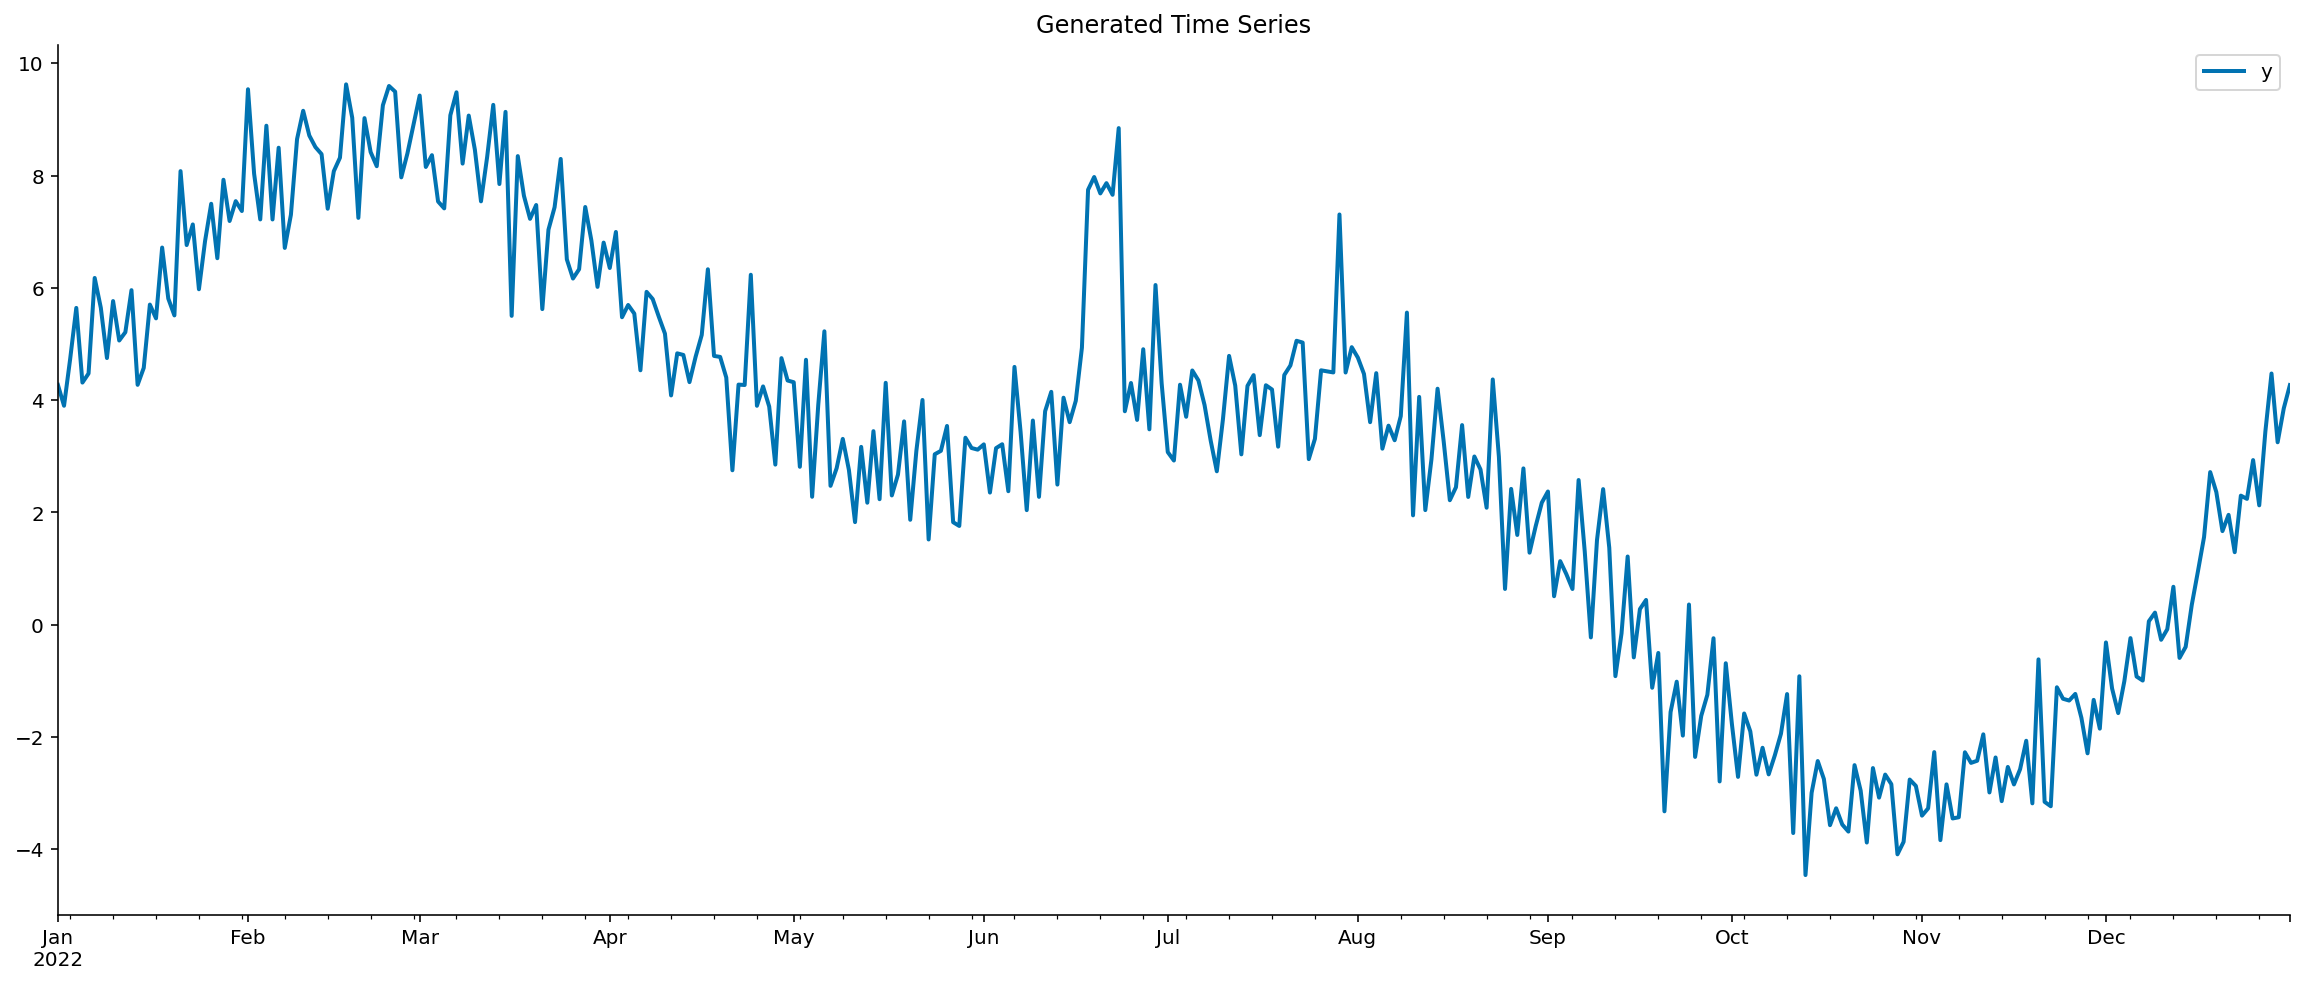

In [4]:
# Set a random seed for reproducibility
np.random.seed(42)

# Generate a DataFrame with dates for the year 2022
range_of_dates = pd.date_range(start="2022-01-01", end="2022-12-31")
X = pd.DataFrame(index=range_of_dates)

# Create a sequence of day numbers and add day of the year information
X["day_nr"] = range(len(X))
X["day_of_year"] = X.index.dayofyear

# Generate components of the target time series
signal_1 = 3 + 4 * np.sin(X["day_nr"] / 365 * 2 * np.pi)
signal_2 = 3 * np.sin(X["day_nr"] / 365 * 4 * np.pi + 365/2)
noise = np.random.normal(0, 0.85, len(X))

# Combine the components to get the target series
y = signal_1 + signal_2 + noise

# Add additional random noise to specific date range (June 18 - June 23)
peak_mask = (y.index.month == 6) & (y.index.day >= 18) & (y.index.day <= 23)
y.loc[peak_mask] = y.loc[peak_mask] + np.random.normal(5, 1, len(y.loc[peak_mask]))

# Convert the target series to a DataFrame and assign a column name
y = y.to_frame()
y.columns = ["y"]

# Plot the generated time series
y.plot(title="Generated Time Series");

## Simple Moving Average

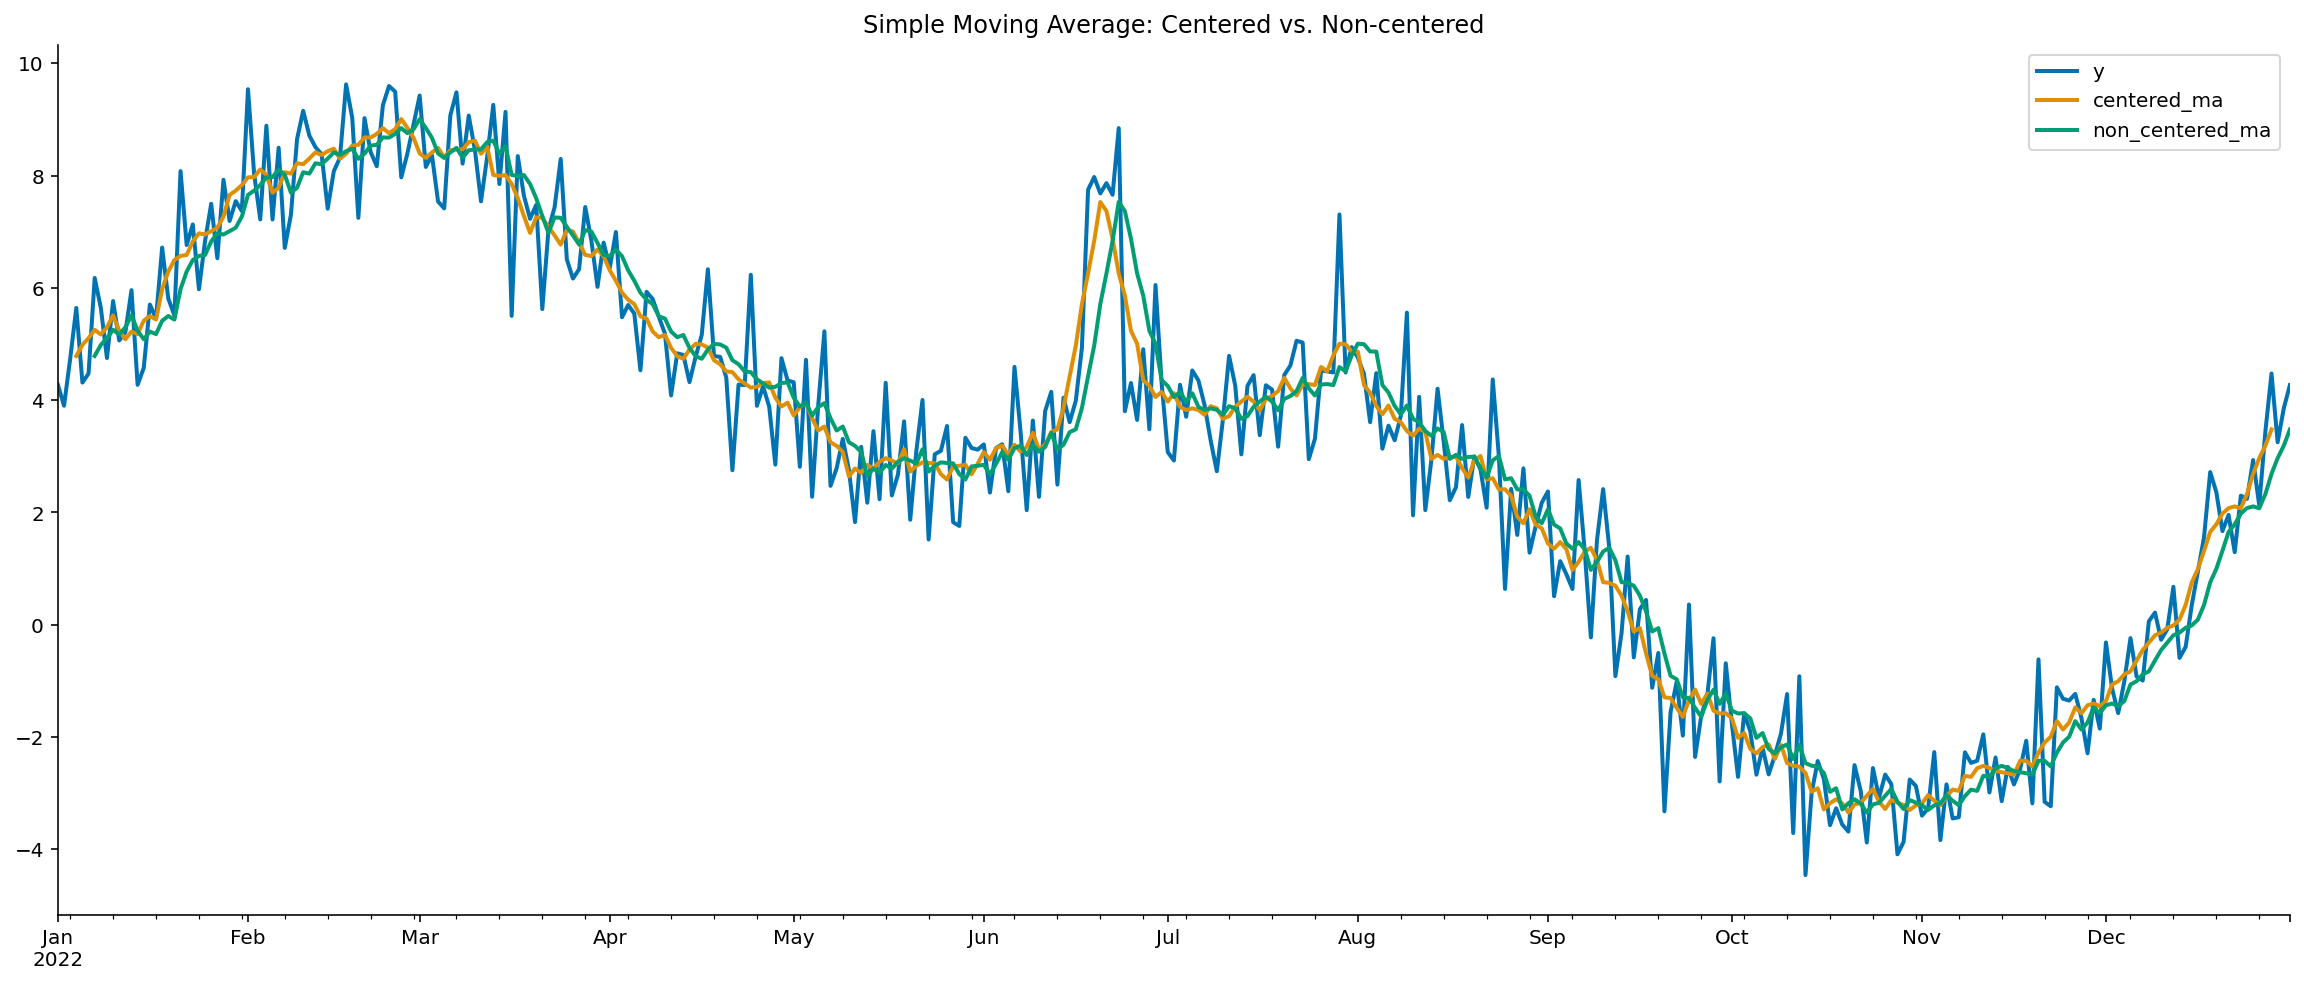

In [5]:
ma_df = y.copy()
WINDOW_SIZE = 7

ma_df["centered_ma"] = ma_df["y"].rolling(window=WINDOW_SIZE, center=True).mean()
ma_df["non_centered_ma"] = ma_df["y"].rolling(window=WINDOW_SIZE, center=False).mean()

ma_df.plot(title="Simple Moving Average: Centered vs. Non-centered");

In [6]:
ma_df.head(15)

,y,centered_ma,non_centered_ma
2022-01-01,4.273237,NaN,NaN
2022-01-02,3.900877,NaN,NaN
2022-01-03,4.735163,NaN,NaN
2022-01-04,5.644148,4.788753,NaN
2022-01-05,4.314070,4.984889,NaN
2022-01-06,4.476064,5.106389,NaN
2022-01-07,6.177711,5.253665,4.788753
2022-01-08,5.646191,5.170691,4.984889
2022-01-09,4.751374,5.298877,5.106389
2022-01-10,5.766098,5.510939,5.253665


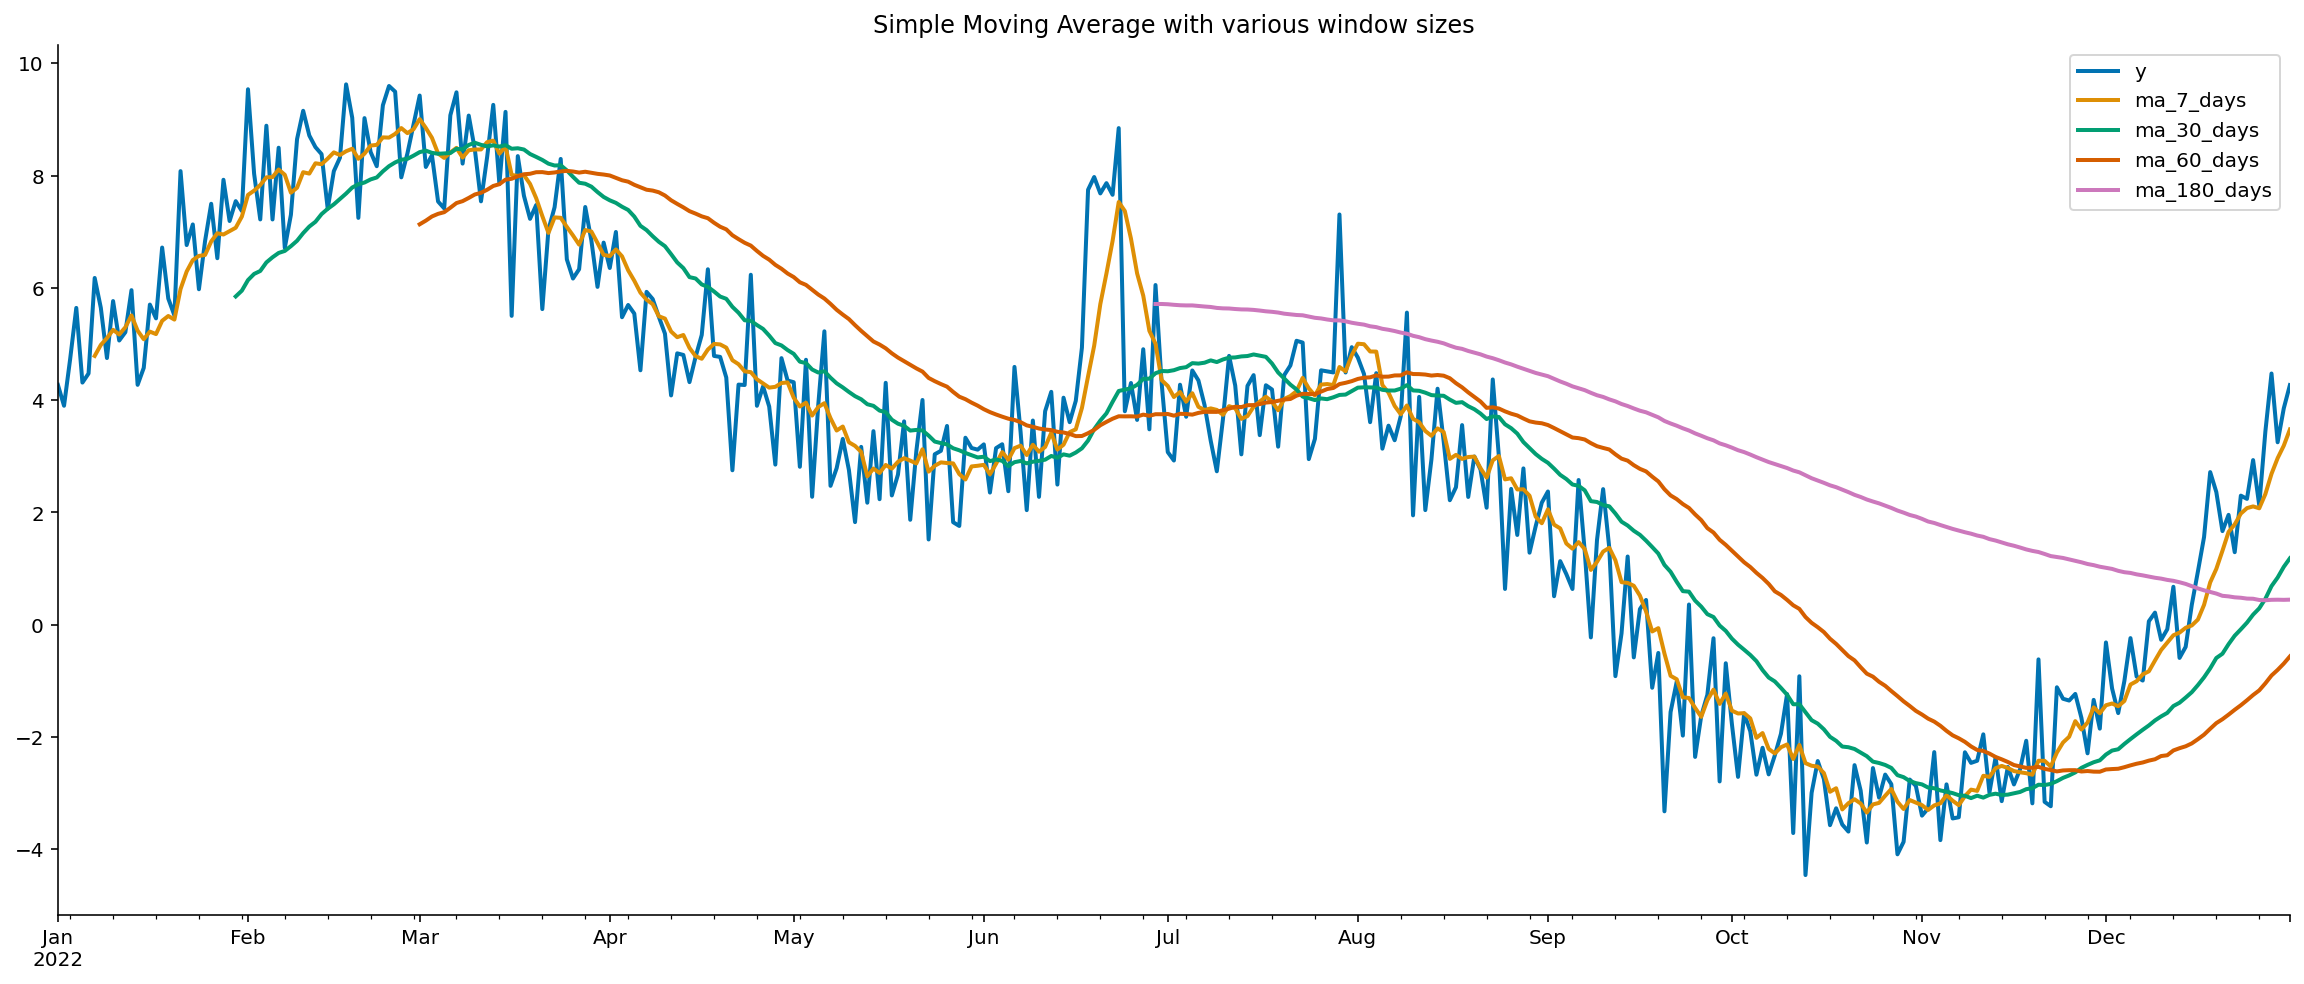

In [7]:
ma_df = y.copy()

for window in [7, 30, 60, 180]:
    ma_df[f"ma_{window}_days"] = ma_df["y"].rolling(window=window).mean()

ma_df.plot(title="Simple Moving Average with various window sizes");

## Exponentially Weighted Moving Average

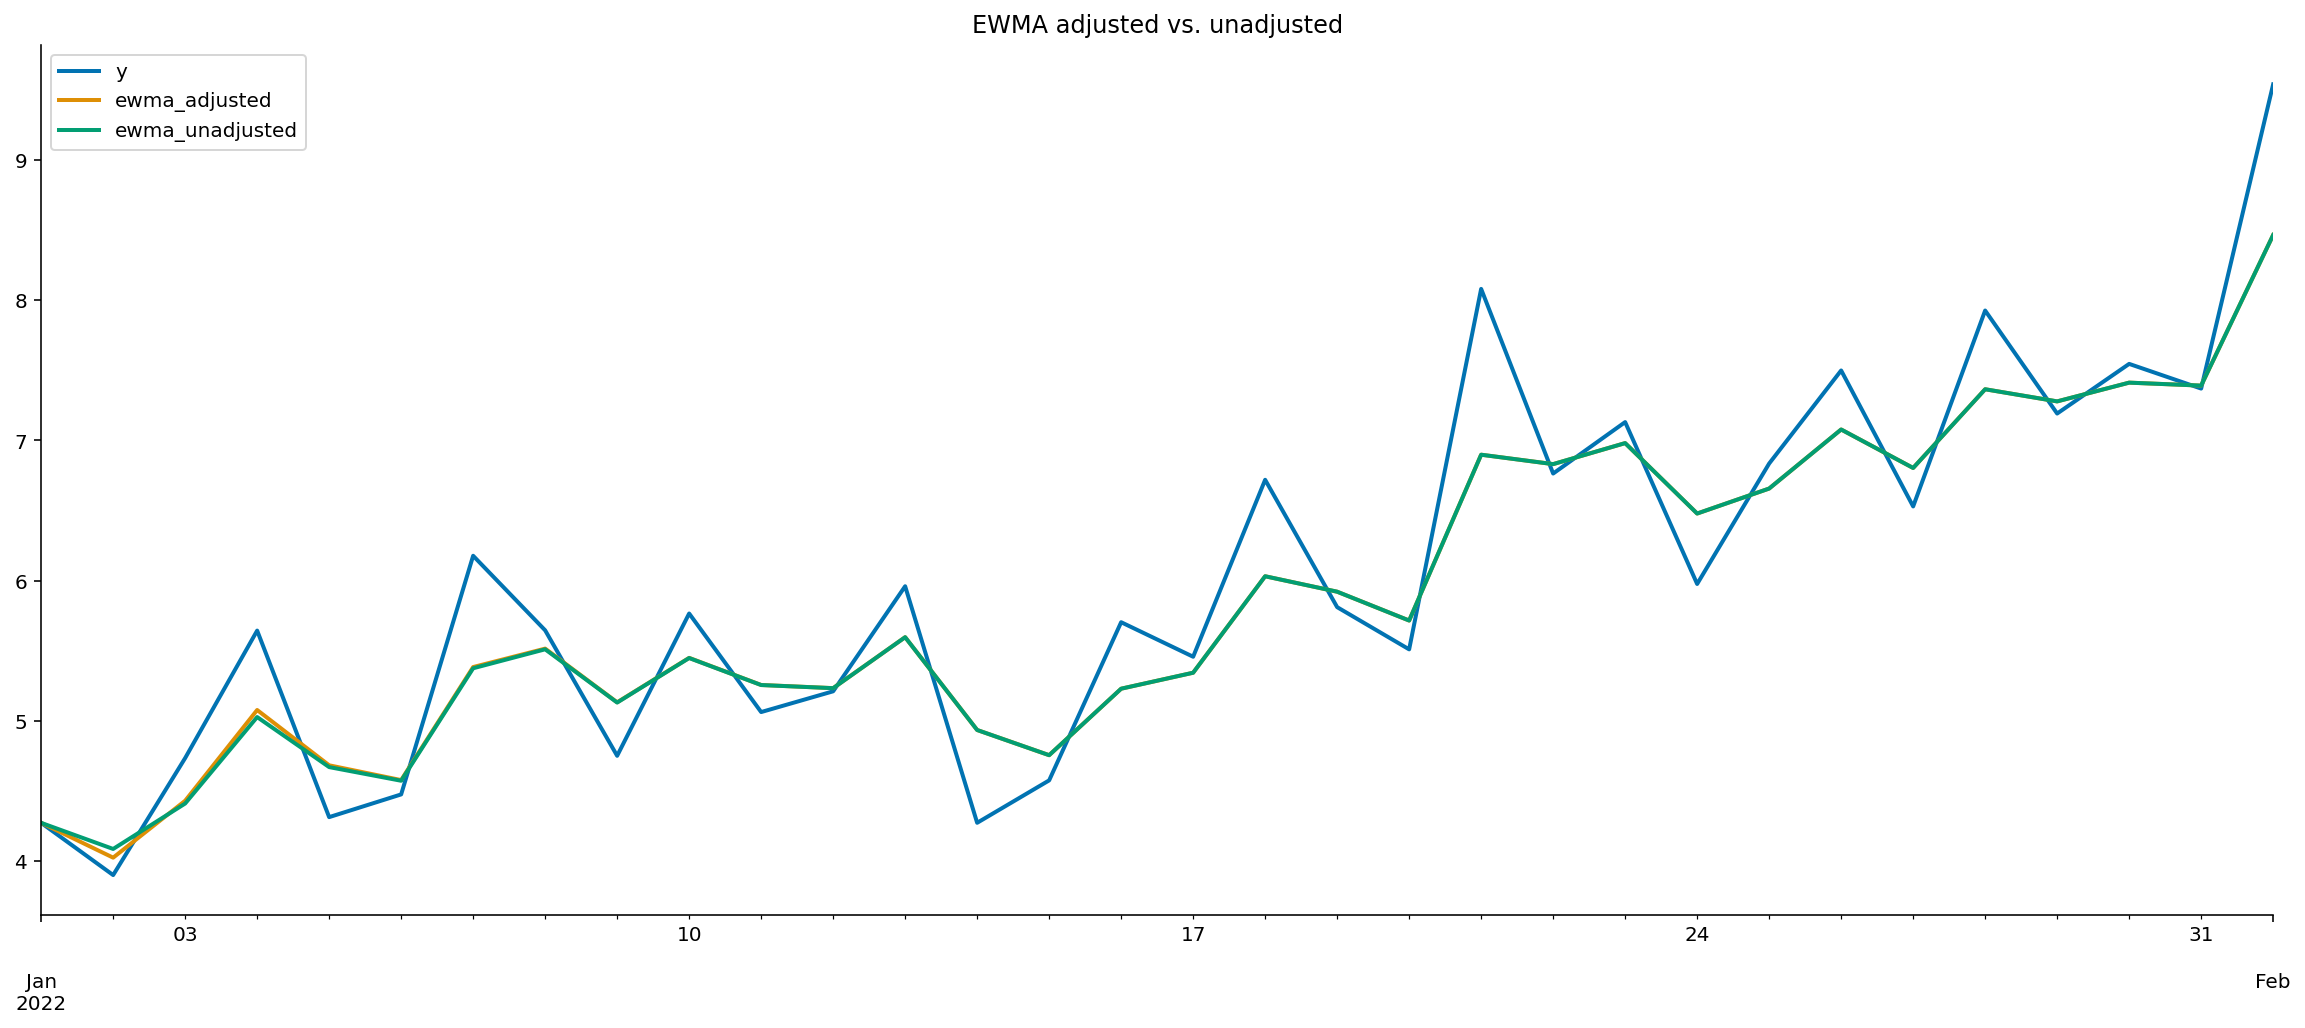

In [8]:
ewma_df = y.copy()

ewma_df["ewma_adjusted"] = ewma_df['y'].ewm(alpha=0.5, adjust=True).mean()
ewma_df["ewma_unadjusted"] = ewma_df['y'].ewm(alpha=0.5, adjust=False).mean()


ewma_df.loc["2022-01-01":"2022-02-01"].plot(title="EWMA adjusted vs. unadjusted");

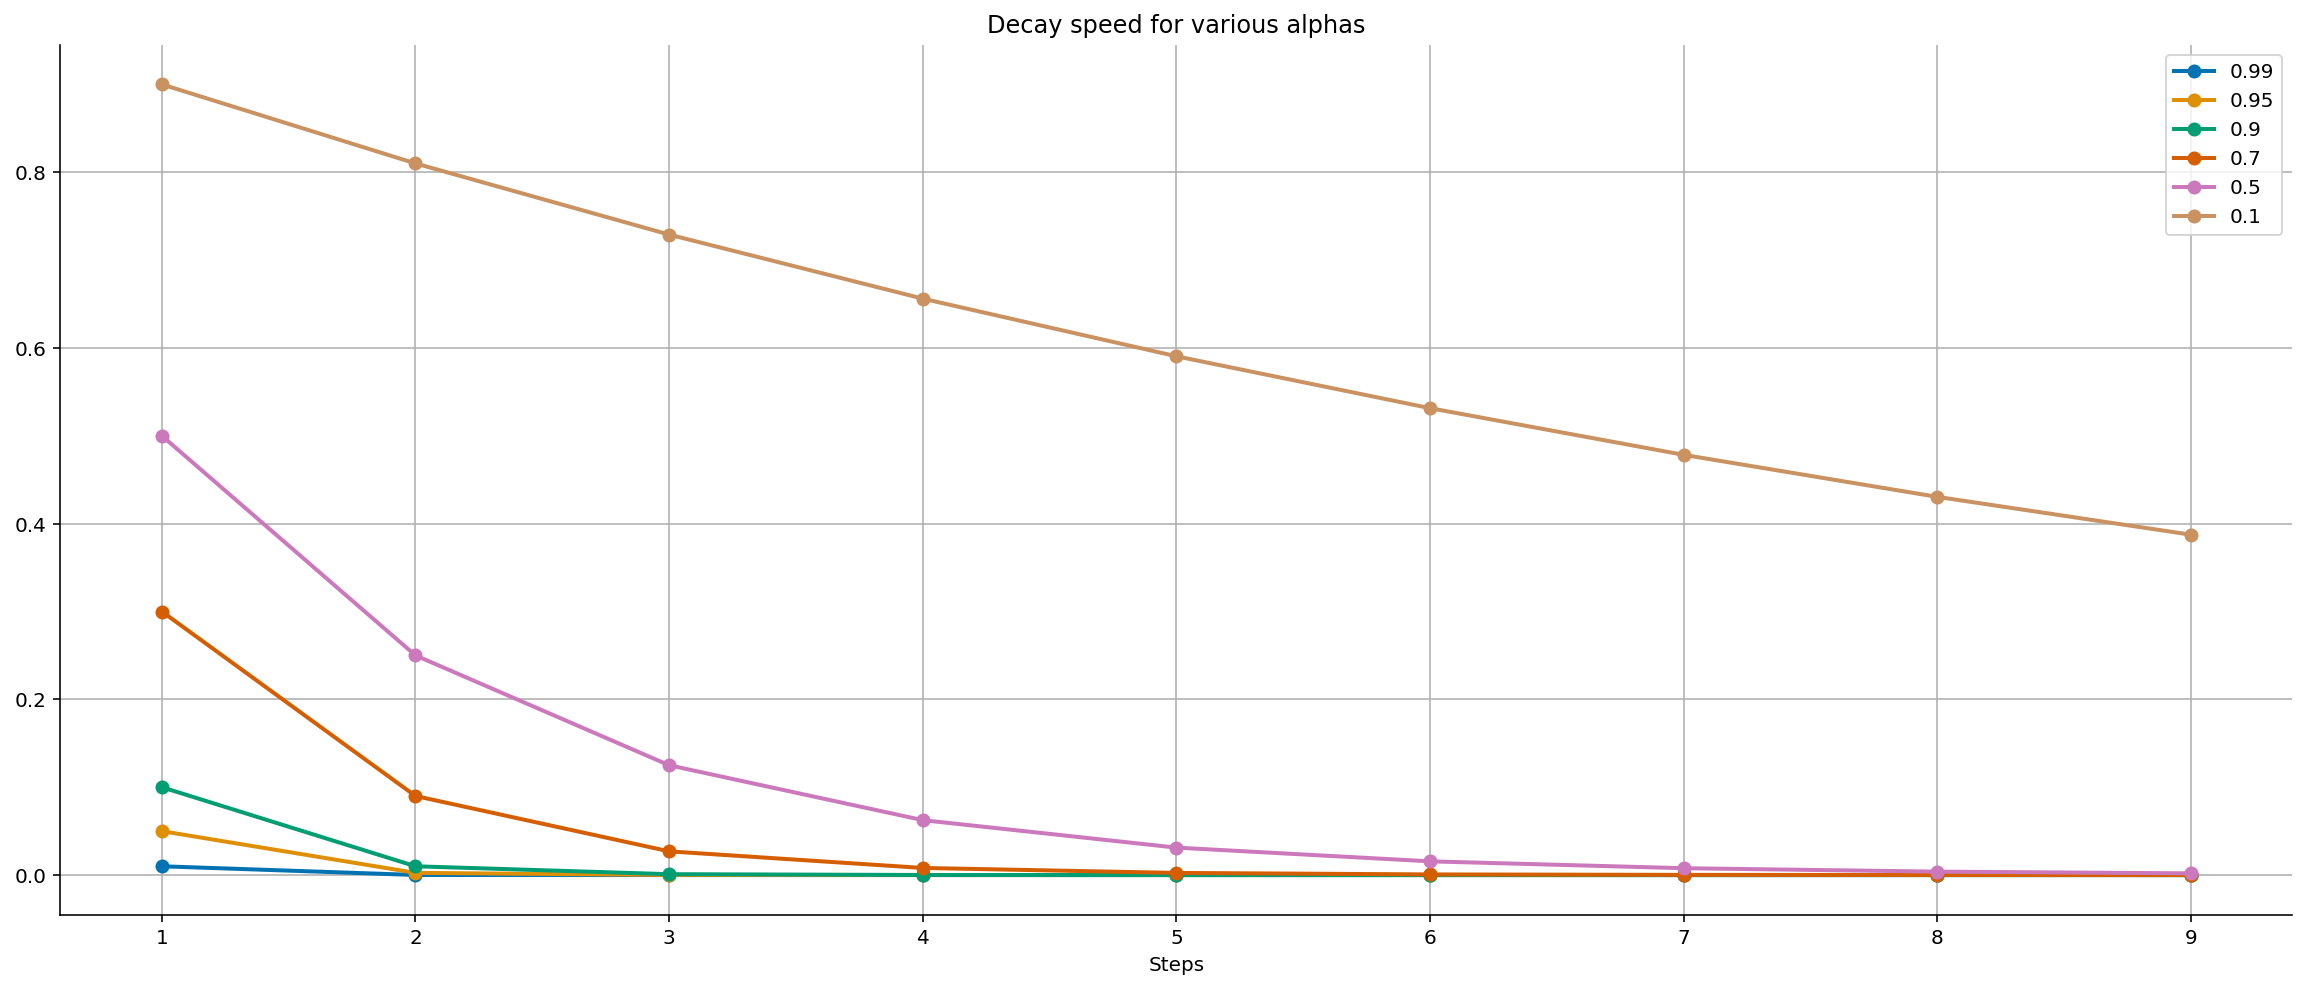

In [9]:
alpha_dict = {}
for alpha in [0.99, 0.95, 0.9, 0.7, 0.5, 0.1]:
    # this calculation assumes we are using the adjusted formula!
    alpha_dict[alpha] = [(1 - alpha) ** power for power in list(range(1, 10, 1))]

df = pd.DataFrame(alpha_dict)
df.index = range(1, len(df) + 1)

# Plot the DataFrame and set the x-label
ax = df.plot(title="Decay speed for various alphas", marker='o')
ax.set_xlabel("Steps", fontsize=10)
plt.grid(True);

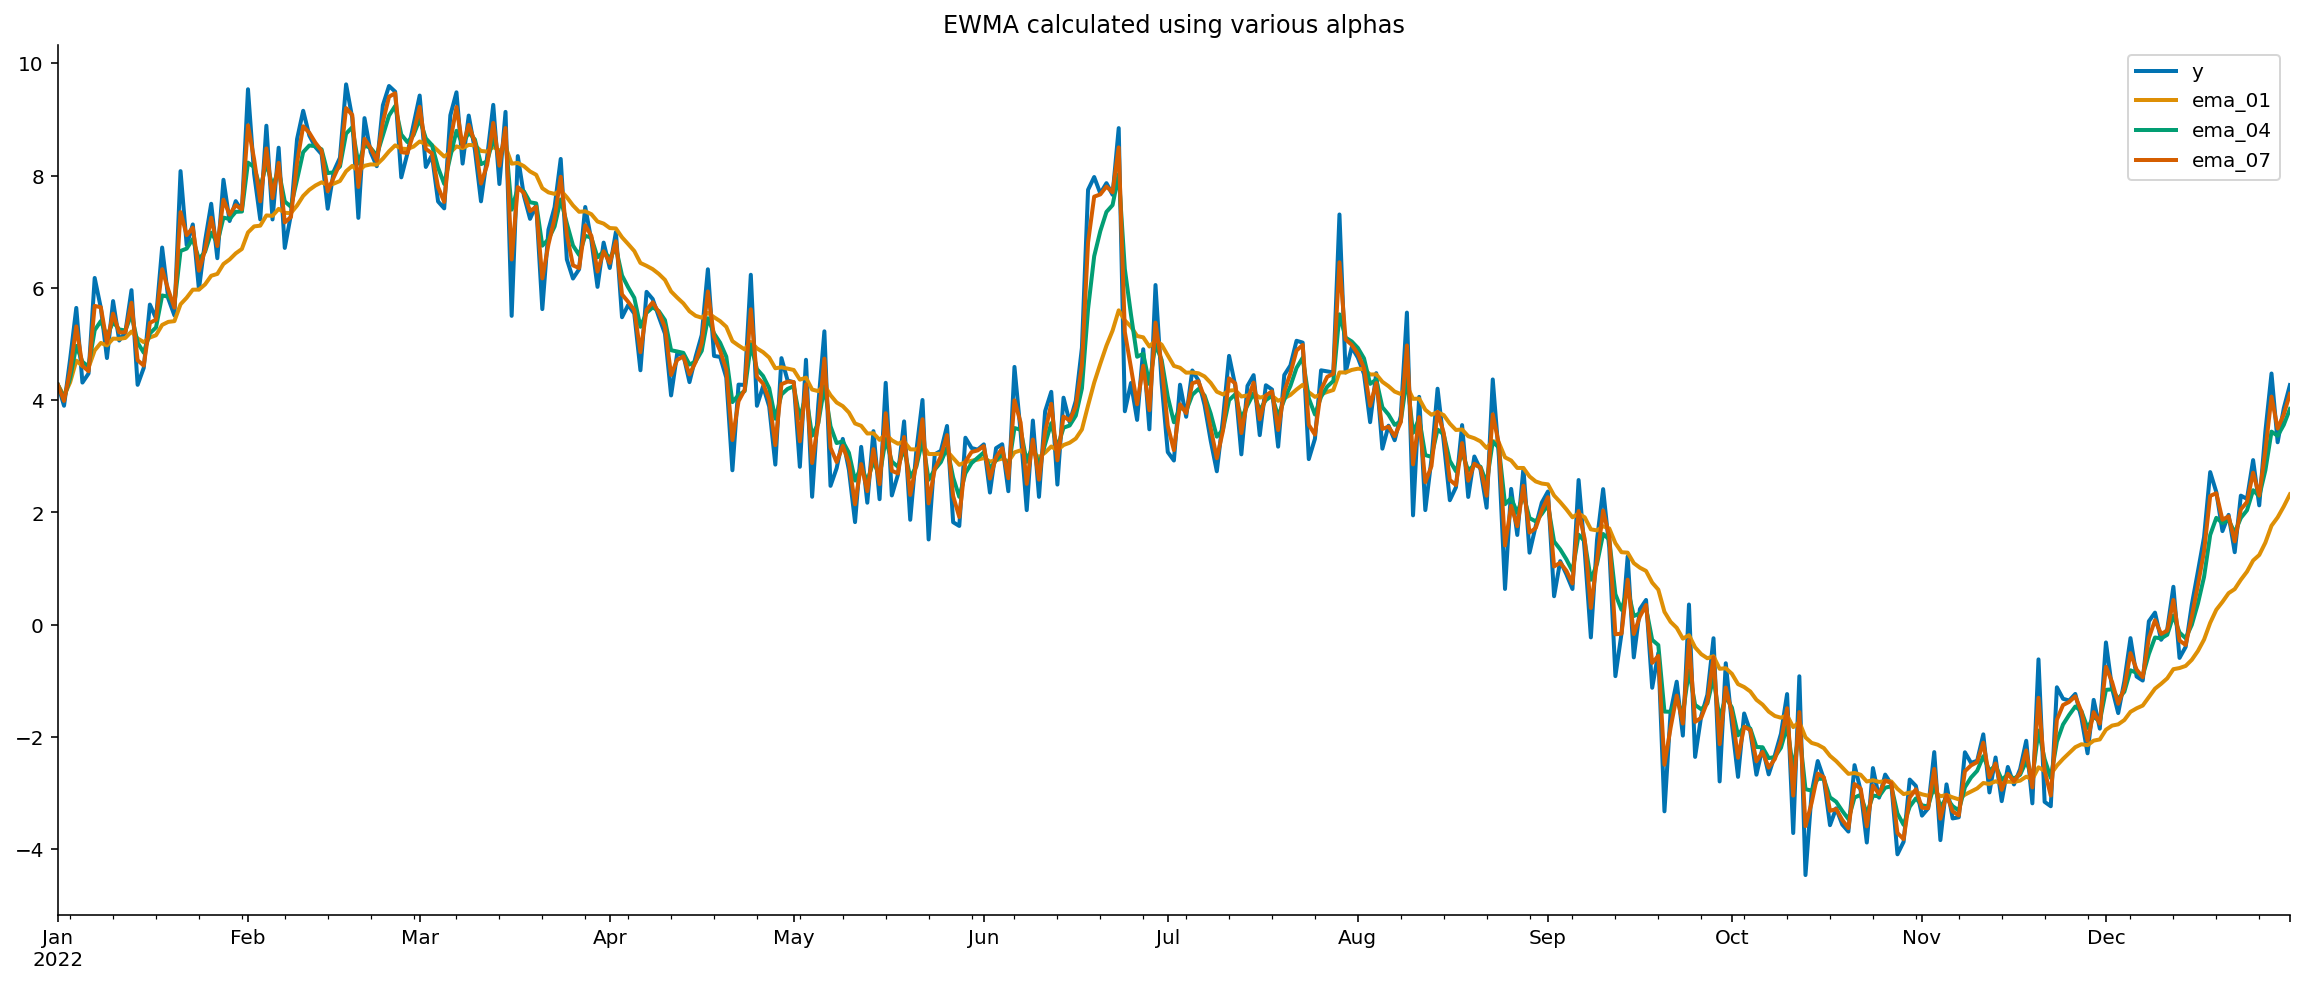

In [10]:
ewma_df = y.copy()
ALPHA_LIST = [0.1, 0.4, 0.7]

for alpha in ALPHA_LIST:
    ewma_df[f'ema_{str(alpha).replace(".", "")}'] = ewma_df['y'].ewm(alpha=alpha).mean()


ewma_df.plot(title="EWMA calculated using various alphas");

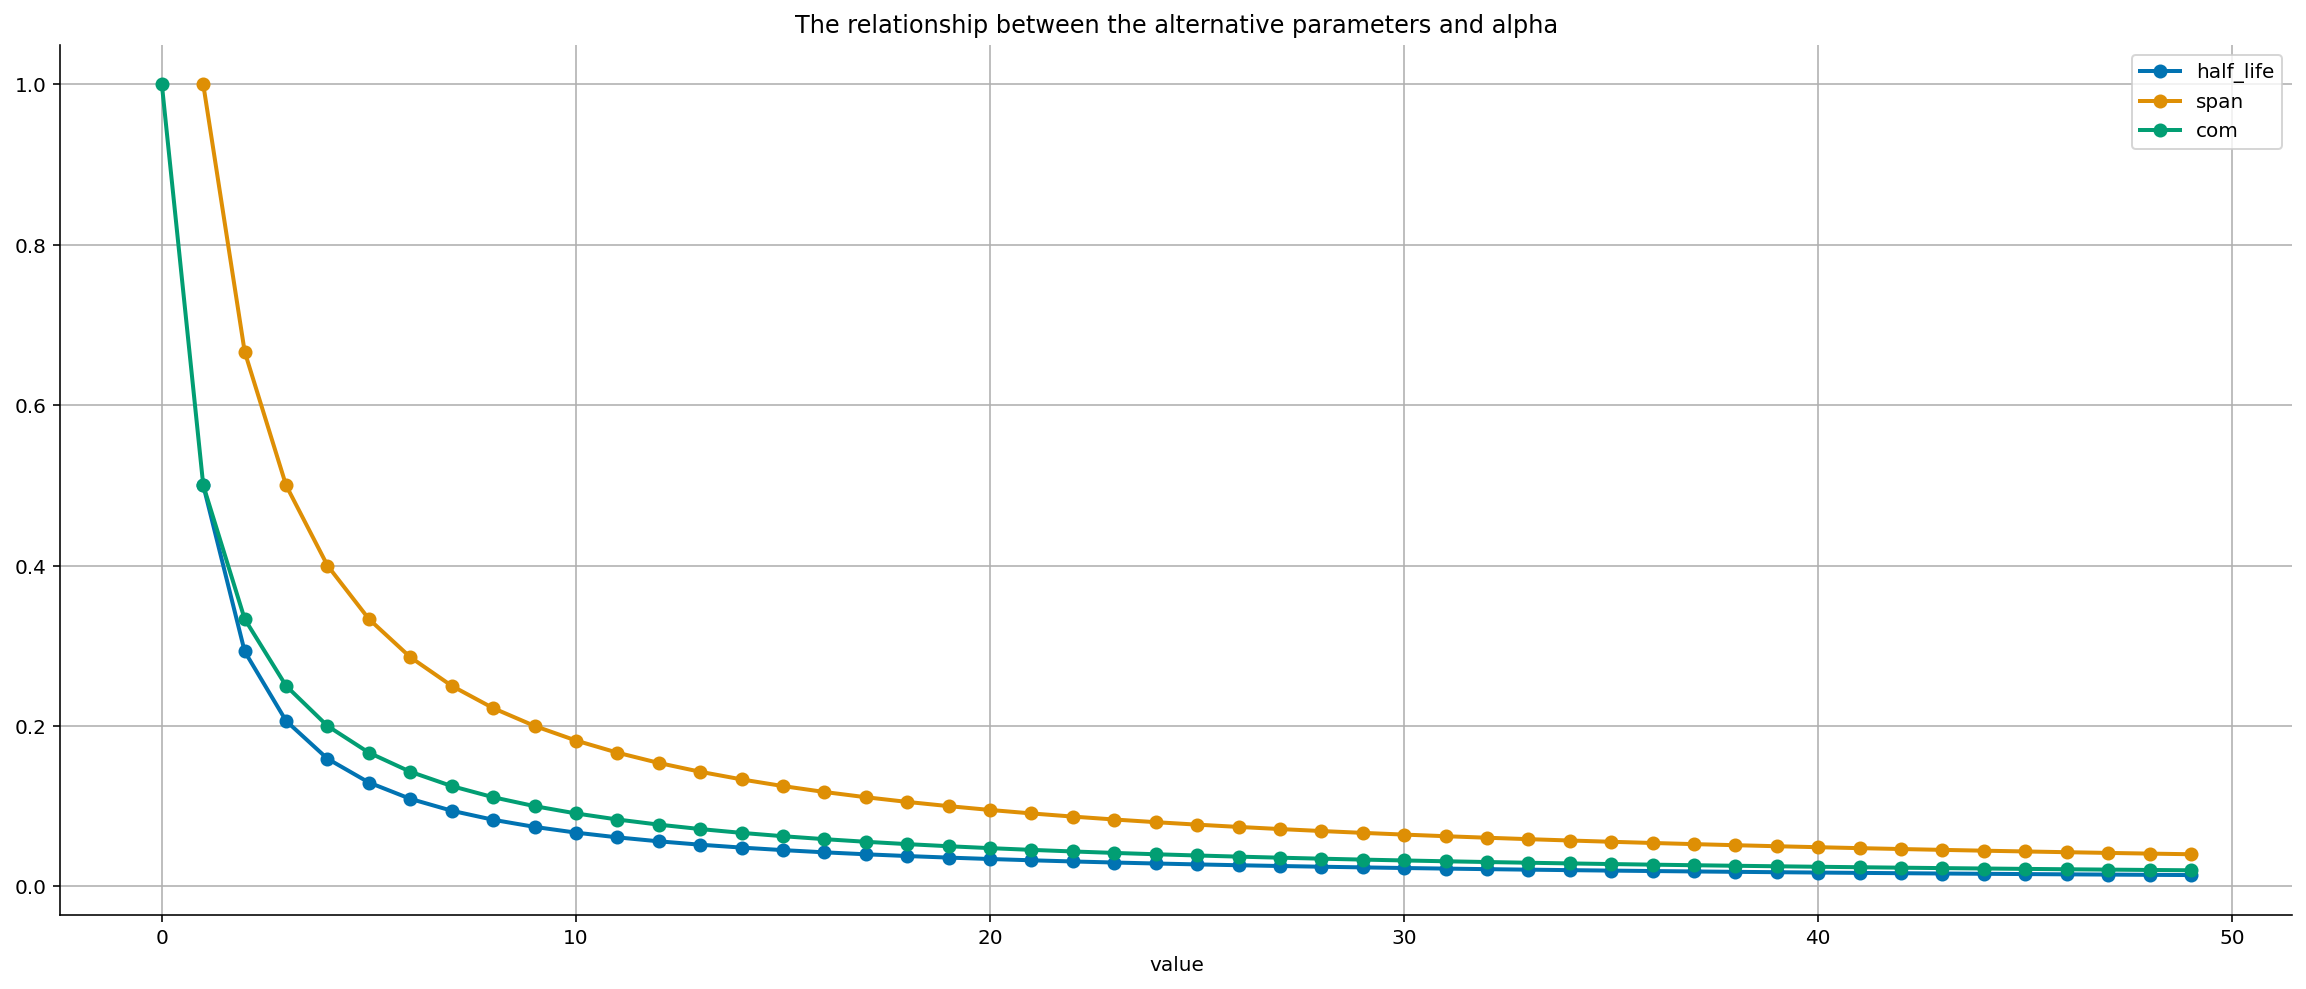

In [11]:
param_df = pd.DataFrame(data={"value": range(0, 50)}).set_index("value")

# half-life
param_df["half_life"] = 1 - np.exp(-np.log(2) / param_df.index)
param_df.loc[0, "half_life"] = np.nan

# span (accounting for missing value for 0)
param_df["span"] = 2/(1+param_df.index)
param_df.loc[0, "span"] = np.nan

# center of mass
param_df["com"] = 1/(1+param_df.index)

param_df.plot(title="The relationship between the alternative parameters and alpha", marker='o')
plt.grid(True);

In [12]:
param_df.head(15)

,half_life,span,com
value,,,
0,NaN,NaN,1.000000
1,0.500000,1.000000,0.500000
2,0.292893,0.666667,0.333333
3,0.206299,0.500000,0.250000
4,0.159104,0.400000,0.200000
5,0.129449,0.333333,0.166667
6,0.109101,0.285714,0.142857
7,0.094276,0.250000,0.125000
8,0.082996,0.222222,0.111111


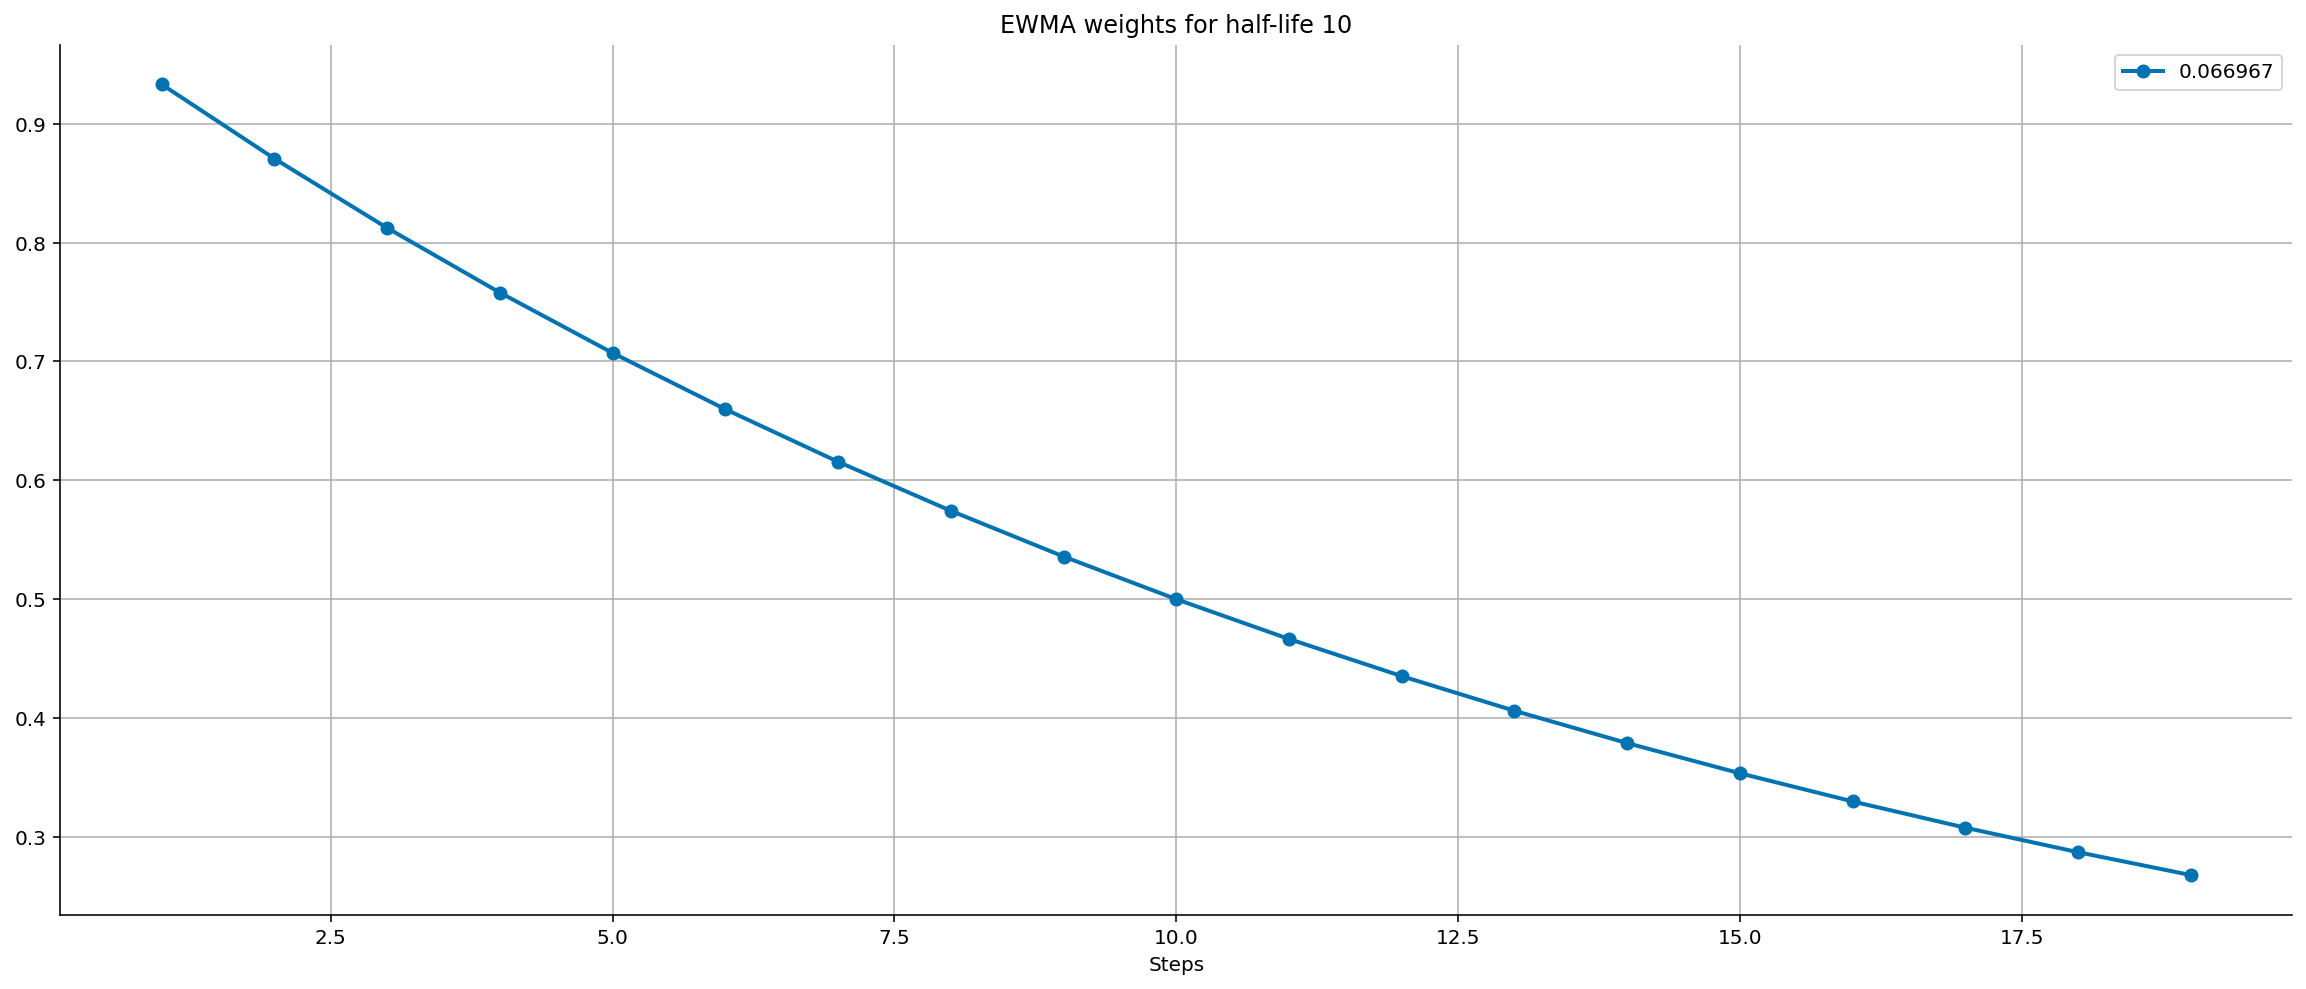

In [13]:
alpha_dict = {}

for alpha in [0.066967]:
    alpha_dict[alpha] = [(1 - alpha) ** power for power in list(range(1, 20, 1))]

df = pd.DataFrame(alpha_dict)
df.index = range(1, len(df) + 1)

# Plot the DataFrame and set the x-label
ax = df.plot(title="EWMA weights for half-life 10", marker='o')
ax.set_xlabel("Steps", fontsize=10)
plt.grid(True);